# Conspace Machine Learning
## Estimating Event Attendance using machine learning

In this project, we will search for a means of estimating an accurate attendance for convention like events using machine learning. Charities use events like these to gather funding for their causes; and having an overage, or running out of merchandise; staff members, even identifiers; can cut into the amount these charities can give.

## Theory
*We can predict the future of convention attendance, by using machine learning on it and similar events*

### Data and Data Sourcing

Data sourcing was sporadic, but we were able to pull data from a few sources to fill the information out. We chose other conventions as the parameters of the machine learning. All of the conventions are in the local area of south east United States, Georgia and Florida; in order to minimize collinearity and maximize significance. We also limited the data collection to a sample of conventions that have a general theme.

This leaves us the data for the events as features, 7 features wide with the years being the row columns, each row responding to the attendance that the event received each year. As some of the targets are only 8 or 9 years old, we will limit the data to 12 years.

**Data Sources**  
https://jax.wasabicon.com/about/  
https://en.wikifur.com/wiki/Megaplex  
https://fancons.com/events/info/9237/omni-fandom-expo-2018  
https://www.clickorlando.com/news/2017/05/27/thousands-of-fans-attend-megacon-2017/  
https://en.wikipedia.org/wiki/MegaCon  
https://en.wikipedia.org/wiki/Furry_Weekend_Atlanta  
https://en.wikipedia.org/wiki/MomoCon  
https://en.wikipedia.org/wiki/Dragon_Con  

### Data Cleaning  

With the data sources secured, we realize we have a few holes in the data, especially regarding to the covid-19 pandemic. Wasabicon for example, didn't start until 2020, which means we need to fill in that data. I have zero'd out the data to show that the convention didn't happen and allow the model to build on that rate. 

As for the covid 19 Pandemic, the solution came as cutting off 2020 and 2021 off the record, as conventions would show similar growth bumps from the attendance for the model to calculate.

### Project Setup
We'll start by setting up the project and adding the model into it. We will also drop the year itself in favor of a Digital Year starting at 1, so we can process the data more efficiently. We do see that data is missing for Wasabi Con and AWA, but we do not need worry about those, as they haven't happened yet and won't affect predictions.

For this project, we will pick **AWA** and **FWA** as our targets, randomly chosen from the pool for one we can predict, and one that has already been completed that we can test for accuracy.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [2]:
df = pd.read_csv("data/condata.csv")
df.drop(columns=['Year'], inplace=True)
df.describe(include='all')

,YearD,DragonCon,MomoCon,FanExpo,Megaplex,AWA,FWA,WasabiCon
count,12.000000,12.000000,12.000000,12.000000,12.000000,11.000000,12.000000,11.000000
mean,7.500000,64583.333333,25047.250000,91916.666667,2126.666667,23795.545455,4108.833333,2813.454545
std,3.605551,16081.939805,14297.324156,36965.483491,1621.920317,8629.330164,2631.285681,3098.242514
min,2.000000,30000.000000,7800.000000,40000.000000,410.000000,12499.000000,1564.000000,0.000000
25%,4.750000,56000.000000,11725.000000,63250.000000,772.000000,15917.500000,2272.500000,950.000000
50%,7.500000,67500.000000,25450.000000,98500.000000,1666.000000,25107.000000,3341.500000,2301.000000
75%,10.250000,77750.000000,36300.000000,105000.000000,2855.250000,31750.000000,5306.000000,3308.500000
max,13.000000,85000.000000,48000.000000,160000.000000,5189.000000,35000.000000,10328.000000,11042.000000


### Exploratory Data Analysis

We can see with the data year by year that there is a general increase in attendance that matches close with the neighboring conventions. However as shown in the graphs below; there is correlations between the conventions. Some Conventions have high correlations, Megaplex and FanExpo both share a linear correlation, which makes some sense as they are both the Floriday region conventions. However they all don't correlate, as WasabiCon and DragonCon don't correlate well at all.

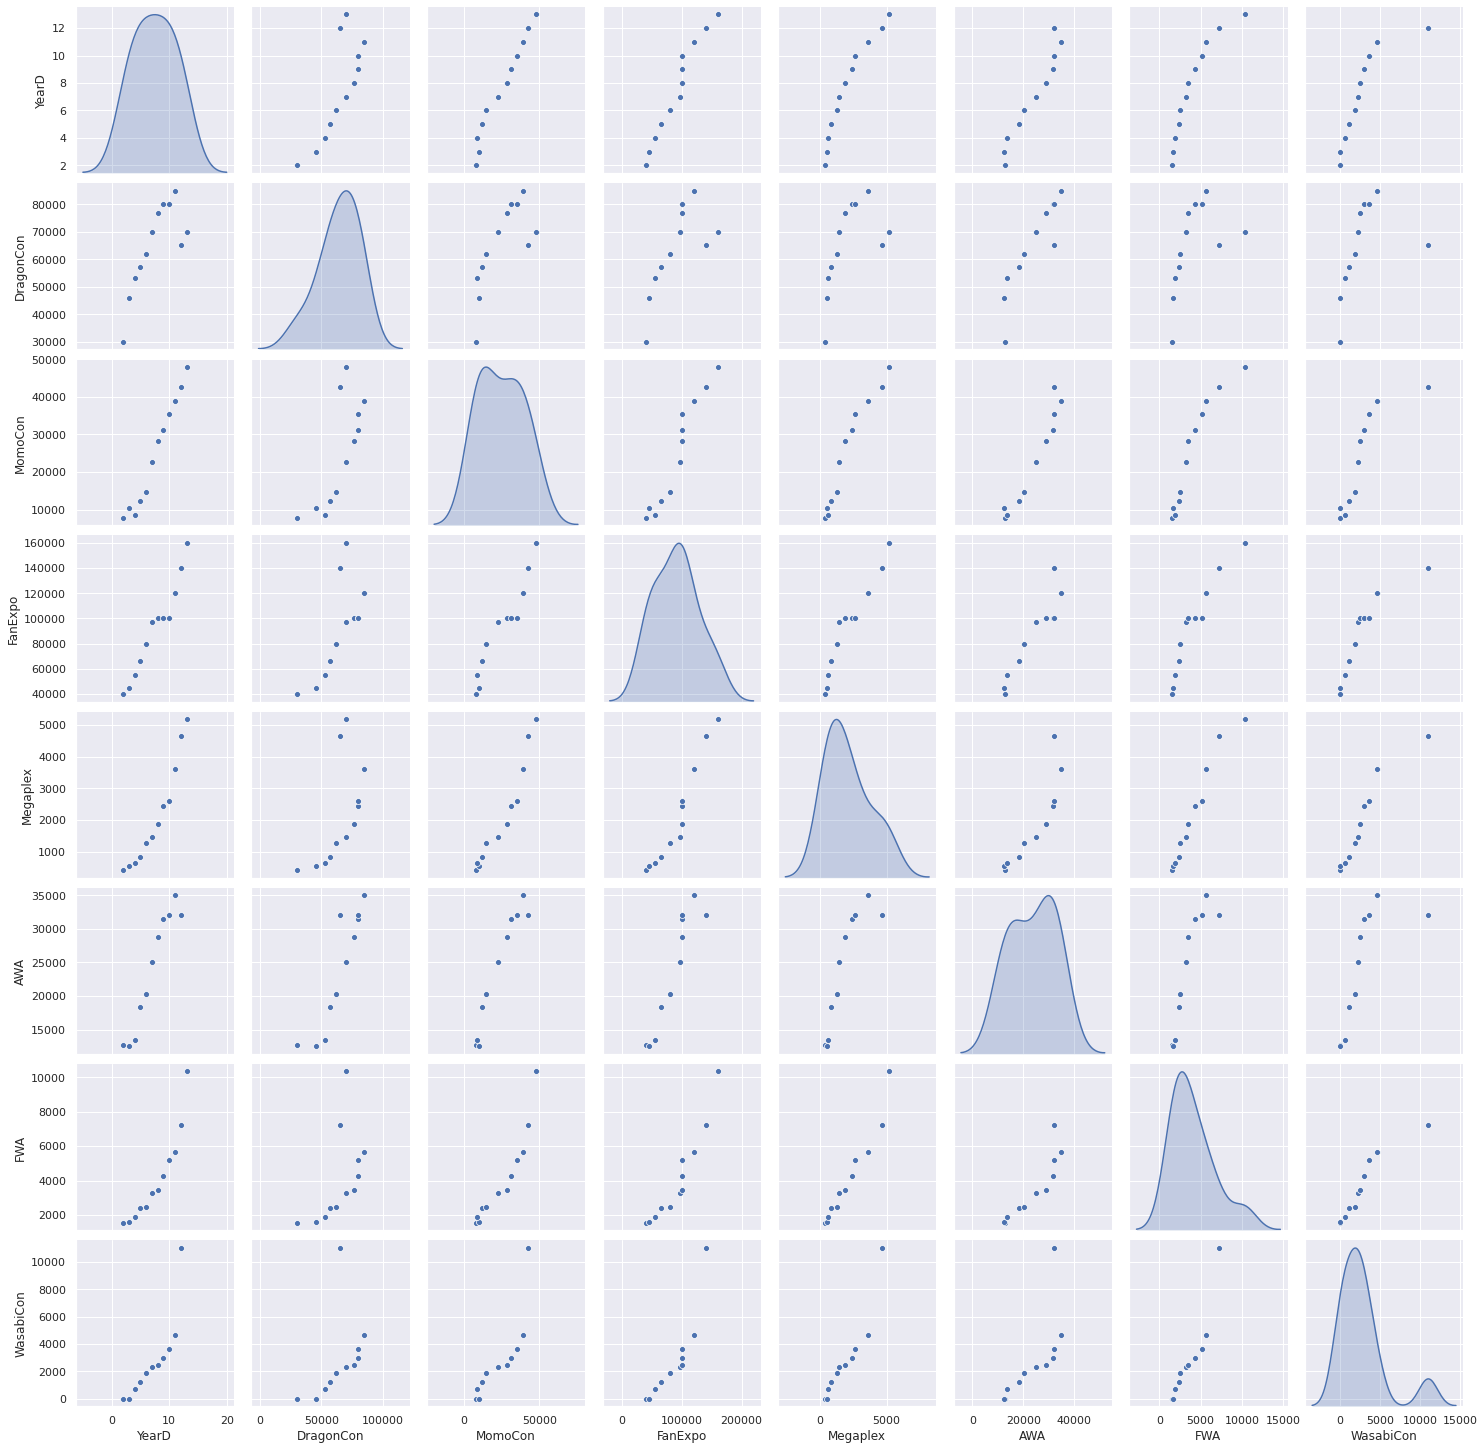

In [3]:
sns.pairplot(df, diag_kind='kde')

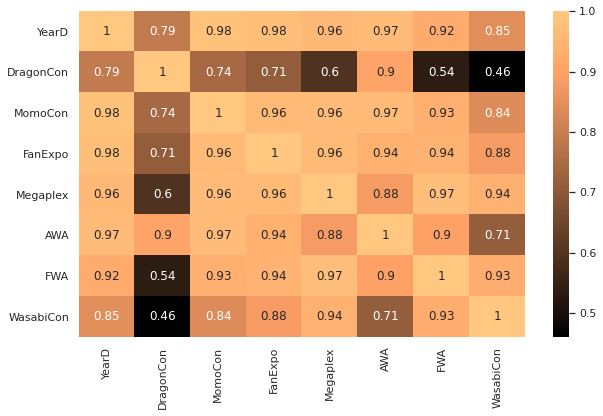

In [4]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), cmap='copper', annot=True)

## Models

### Multi-Linear Regression
For the examples. I tried using Multi Linear Approach, Using the year as a correlation in the result. These are hand fitted for a well match for both AWA and FWA as examples. Originally I ran the data over the years, but switching the data to a decimal format received better results. 

We can see the p values being significant with a 0 value and an r-squared of .978, suggesting a very large fit.

In [5]:
modelAWA = smf.ols(formula=f"AWA ~ FanExpo:DragonCon", data=df).fit()
print(modelAWA.summary())
modelFWA = smf.ols(formula=f"FWA ~ MomoCon:Megaplex", data=df).fit()
print(modelFWA.summary())

                            OLS Regression Results                            
Dep. Variable:                    AWA   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     311.3
Date:                Sat, 14 Oct 2023   Prob (F-statistic):           2.74e-08
Time:                        16:51:05   Log-Likelihood:                -95.131
No. Observations:                  11   AIC:                             194.3
Df Residuals:                       9   BIC:                             195.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          7361.8939   1038.75

### Polynomial Regression
The next step in fitting was for polynomial regression. The fit for AWA was very well, so we won't be touching this one. However the fit for FWA was just short of where I'd like it to be, so we will try polynomial regression to get it where it needs to be. As this is automatable, we'll just loop through it. 

Using this we were able to get the r square to where we wanted it to be. This will allow us to tune the results better. 

In [6]:
r2=0
result=0
for x in range(1,11):
    modx = f"FWA ~ MomoCon:np.power(Megaplex,{x})"
    modeln = smf.ols(formula=modx, data=df).fit()
    if modeln.rsquared > r2:
        r2=modeln.rsquared
        result=x
r2=0
resulta=0
for x in range(1,11):
    modx = f"AWA ~ FanExpo:np.power(DragonCon,{x})"
    modeln = smf.ols(formula=modx, data=df).fit()
    if modeln.rsquared > r2:
        r2=modeln.rsquared
        resulta=x
modelFWA = smf.ols(formula=f"FWA ~ MomoCon:np.power(Megaplex,{result})", data=df).fit()
print(f"best result is to the power of: {result}")
modelAWA = smf.ols(formula=f"AWA ~ FanExpo:np.power(DragonCon,{resulta})", data=df).fit()
print(f"best result is to the power of: {resulta}")
modelAWA.summary()


best result is to the power of: 1
best result is to the power of: 1


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    AWA   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     311.3
Date:                Sat, 14 Oct 2023   Prob (F-statistic):           2.74e-08
Time:                        16:51:05   Log-Likelihood:                -95.131
No. Observations:                  11   AIC:                             194.3
Df Residuals:                       9   BIC:                             195.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                       7361.8939   1038.757      7.087      0.000    5012.062    9711.726
FanExpo:np.power(DragonCon, 1)  2.794e-06   1.58e-07     17.643      0.000    2.44e-06    3.15e-06
==============================================================================
Omnibus:                        1.437   Durbin-Watson:                   1.546
Prob(Omnibus):                  0.488   Jarque-Bera (JB):                0.969
Skew:                           0.463   Prob(JB):                        0.616
Kurtosis:                       1.879   Cond. No.                     1.48e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.48e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [7]:
modelFWA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    FWA   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     324.4
Date:                Sat, 14 Oct 2023   Prob (F-statistic):           5.96e-09
Time:                        16:51:05   Log-Likelihood:                -89.950
No. Observations:                  12   AIC:                             183.9
Df Residuals:                      10   BIC:                             184.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                      1787.6687    188.653      9.476      0.000    1367.323    2208.014
MomoCon:np.power(Megaplex, 1)  3.146e-05   1.75e-06     18.011      0.000    2.76e-05    3.54e-05
==============================================================================
Omnibus:                        0.325   Durbin-Watson:                   1.872
Prob(Omnibus):                  0.850   Jarque-Bera (JB):                0.452
Skew:                          -0.249   Prob(JB):                        0.798
Kurtosis:                       2.190   Cond. No.                     1.48e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.48e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

It looks like a power of 2 is the best one, and brings our R squared value to 0.980
; which is exactly where we'd like it to be. With the correct features picked out we can plot the comparison between the orders. 


### Results, Testing and Analysis
With the models fitted, we can test it with the final row of data as shown below. For testing we are using historic data from before the fitting. 

The data for our test fpred, shows an error of 17 percent, which while low, is higher than where we wish to be. We can use this with some test data to show an estimate for AWA, which as of this writing hasn't finished for the year; and feel rather confident that it will be in a few percentage points of the estimate below.

We then calculated the historical data to match accuracies, and found the trend to be very close. Calculated below is the Estimates and percentage differences for the data, as well as charts showing how far away the data is from the report using historic data. 

It's rather obvious these metrics were chosen to show the models estimates compared to the actual data from the events. A satisfactory result will be one with a close approximation to the target attendance below 5%.

FWA Estimate: 1888.2849162375196. Percentage Difference: 18.79%
AWA Estimate: 38655.86228386062


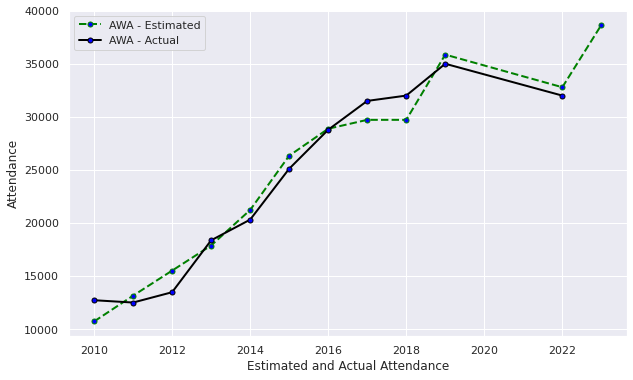

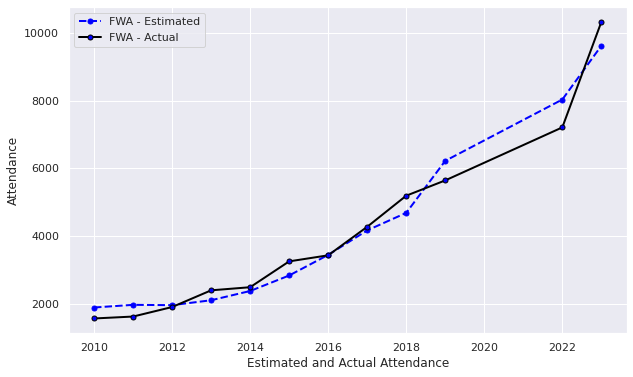

In [8]:
x=df.tail(1)
xt = pd.read_csv("data/testing.csv")
fpred = modelFWA.predict(xt)
apred = modelAWA.predict(x)
percent=abs(fpred.iloc[0]-xt["FWA"].iloc[0])/((fpred.iloc[0]+xt["FWA"].iloc[0])/2)*100
print(f'FWA Estimate: {fpred.iloc[0]}. Percentage Difference: {percent:.2f}%')
print(f'AWA Estimate: {apred.iloc[0]}')

years = [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2022,2023]
aactual=df['AWA']
aestimated=modelAWA.predict(df)
factual=df['FWA']
festimated=modelFWA.predict(df)
plt.figure(figsize=(10,6))

plt.plot(years, aestimated, color='green', linestyle='dashed', linewidth = 2,
         marker='o', markerfacecolor='blue', markersize=5, label= 'AWA - Estimated')
plt.plot(years, aactual, color='black', linewidth = 2,
         marker='o', markerfacecolor='blue', markersize=5, label= 'AWA - Actual')
plt.legend()
plt.xlabel('Estimated and Actual Attendance')
plt.ylabel('Attendance')
plt.show()
plt.figure(figsize=(10,6))
plt.plot(years, festimated, color='blue', linestyle='dashed', linewidth = 2,
         marker='o', markerfacecolor='blue', markersize=5, label= 'FWA - Estimated')
plt.plot(years, factual, color='black', linewidth = 2,
         marker='o', markerfacecolor='blue', markersize=5, label= 'FWA - Actual')
plt.legend()
plt.xlabel('Estimated and Actual Attendance')
plt.ylabel('Attendance')
plt.show()

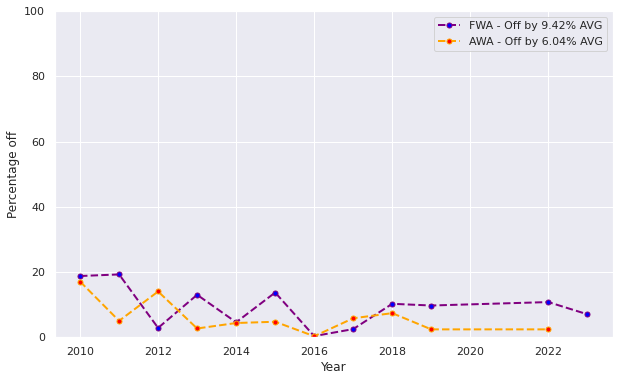

In [9]:
plt.figure(figsize=(10,6))

aper=abs(aestimated-aactual)/((aestimated+aactual)/2)*100
fper = abs(festimated-factual)/((festimated+factual)/2)*100
years = [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2022,2023]
plt.plot(years, fper, color='purple', linestyle='dashed', linewidth = 2,
         marker='o', markerfacecolor='blue', markersize=5, 
         label=f"FWA - Off by {(sum(fper) / len(fper)):.2f}% AVG")
plt.ylim(0, 100)
plt.plot(years, aper, color='orange', linestyle='dashed', linewidth = 2,
         marker='o', markerfacecolor='red', markersize=5, 
         label= f"AWA - Off by {(sum(aper[:-1]) / len(aper[:-1])):.2f}% AVG")
plt.legend()
plt.xlabel('Year')
plt.ylabel('Percentage off')
plt.show()

We see from the charts that we can find con attendance very well by estimating it from the attendance of similar conventions around it. As the years go on the percentage off drops, as the data gets stronger. However we do expect some differences, events come up and change; and cons  start to show more stable changes as they age.

**Future Considerations**
Things we can do to improve accuracy on future versions of this project may include predicting from the previous year instead of the full calendar year. This will atune the data better for an upcoming event; however wasn't necessary to show evidence towards the theory that the 

We may also feel more confident in the models and process with more data, as the more data points we have the better the fit we can get into the model. 

## Conclusion

We have a solid conclusion that attendance of events are correlated, and can be used to predict future changes and growth, barring unforseen variables. About 10% of the data was in estimates as well, and having more precise data could get the error rate even lower as well.

As stated above, we would consider improving the accuracy by changing the year to end with the event and collect more data points to even things out. 

This model is usable as is for some applications, however is not precise enough just yet for good estimates of attendance. Where if the problem can be off by 500 or 1000; it will be usable, anything more precise may need a couple more years of data.
